# EEE4114F: Digital Signals Processing

# Classification of Hand-Drawn Electronic Components

A machine learning project by Bradley Carthew (CRTBRA002) and Sthabiso Lushaba (LSHSTH002)

## 1. Data Collection & Preprocessing

### 1.1. Split the Data using Stratified Random Sampling 

In [1]:
#Importing Python packages
import os
import shutil
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import torchvision
import torchvision.transforms as transforms 
import torch.nn as nn 
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
#Specify source, train and test directory paths
src_dir = "data/SolvaDataset_200_v3"
train_dir = "data/train"
test_dir = "data/test"

#Make train and test directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [3]:
#Populate train and test directories with data from the Kaggle dataset
for component_dir in os.listdir(src_dir):
    #Make directories for component in train and test directories if they do not already exist
    os.makedirs(os.path.join(train_dir, component_dir), exist_ok=True)
    os.makedirs(os.path.join(test_dir, component_dir), exist_ok=True)
    
    #Populate array with .bmp files from component folder
    component_bmps = [filename for filename in os.listdir(os.path.join(src_dir, component_dir)) if filename.endswith(".bmp")]
    
    #Populate train and test arrays for component using random sampling
    train_bmps, test_bmps = train_test_split(component_bmps, test_size=0.2, random_state=42)
    
    #Populate train directory with component folder containing .bmps (80%)
    for bmp in train_bmps:
        src_path = os.path.join(src_dir, component_dir, bmp)
        dest_path = os.path.join(train_dir, component_dir, bmp)
        shutil.copyfile(src_path, dest_path)
    
    #Populate test directory with component folder containing .bmps (20%)
    for bmp in test_bmps:
        src_path = os.path.join(src_dir, component_dir, bmp)
        dest_path = os.path.join(test_dir, component_dir, bmp)
        shutil.copyfile(src_path, dest_path)

### 1.2. Create a Custom Dataset

In [4]:
#Create a custom dataset (ElectronicComponentDataset) that inherits the DataSet class
class ElectronicComponentDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))

        self.samples = []
        for class_index, class_name in enumerate(self.classes):
            class_dir = os.path.join(self.root_dir, class_name)
            for file_name in os.listdir(class_dir):
                file_path = os.path.join(class_dir, file_name)
                self.samples.append((file_path, class_index))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        file_path, class_index = self.samples[index]
        img = Image.open(file_path).convert('L')

        if self.transform is not None:
            img = self.transform(img)

        return img, class_index


### 1.3. Load, Batch and Transform the Data

In [5]:
#Specify transformations to perform on the training data
transform_train = transforms.Compose([transforms.ToTensor(), #Map to a tensor
     #Data Augmenetations?
     transforms.Normalize((0.5), (0.5))]) #Normalizing the data to have a mean of 0 and standard deviation of 1.

#Specify transformationt to perform on testing data
transform_test = transforms.Compose([transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

#Specify batch size
batch_size = 32

#Use DataLoader to load the custom dataset for training
trainset = ElectronicComponentDataset(train_dir, transform_train) #Transform data
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True) #Batch, Load and Shuffle data

#Use DataLoader to load the custom dataset for testing
testset = ElectronicComponentDataset(test_dir, transform_test)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

### 1.4. Visualize the Class Distribution

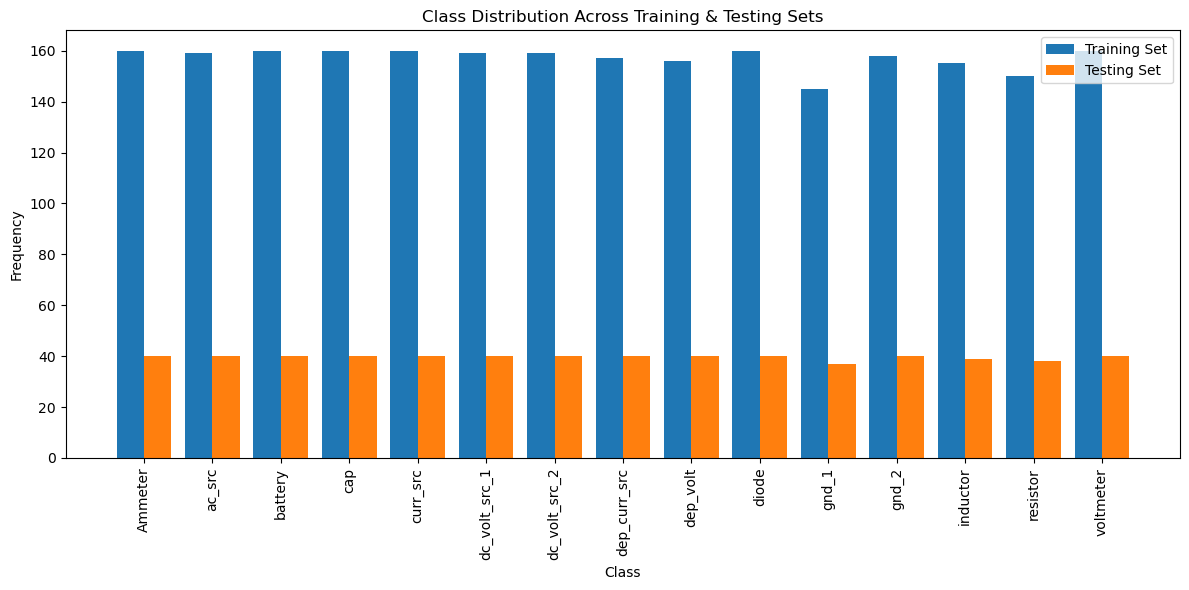

In [6]:
#Retreive train and test set labels from datasets
train_labels = [label for _, label in trainset.samples]
test_labels = [label for _, label in testset.samples]

#Calculate the frequency of classes in train and test sets
train_class_freq = [train_labels.count(label) for label in range(len(trainset.classes))]
test_class_freq = [test_labels.count(label) for label in range(len(testset.classes))]
class_names = trainset.classes

#Plot the class distribution as a bar-chart
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(np.arange(len(class_names))-0.2, train_class_freq, width=0.4, label='Training Set')    
ax.bar(np.arange(len(class_names))+0.2, test_class_freq, width=0.4, label='Testing Set')
ax.set_xticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names, rotation='vertical')
ax.set_xlabel('Class')
ax.set_ylabel('Frequency')
ax.set_title('Class Distribution Across Training & Testing Sets')
ax.legend()
plt.tight_layout()
plt.show()

### 1.5. Visualizing the Data

In [7]:
# Display the batch shape of a feature and label
train_features, train_labels = next(iter(trainloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 1, 120, 120])
Labels batch shape: torch.Size([32])


Label Data:
['Ammeter', 'ac_src', 'battery', 'cap', 'curr_src', 'dc_volt_src_1', 'dc_volt_src_2', 'dep_curr_src', 'dep_volt', 'diode', 'gnd_1', 'gnd_2', 'inductor', 'resistor', 'voltmeter']

Image Data and Associated Labels:


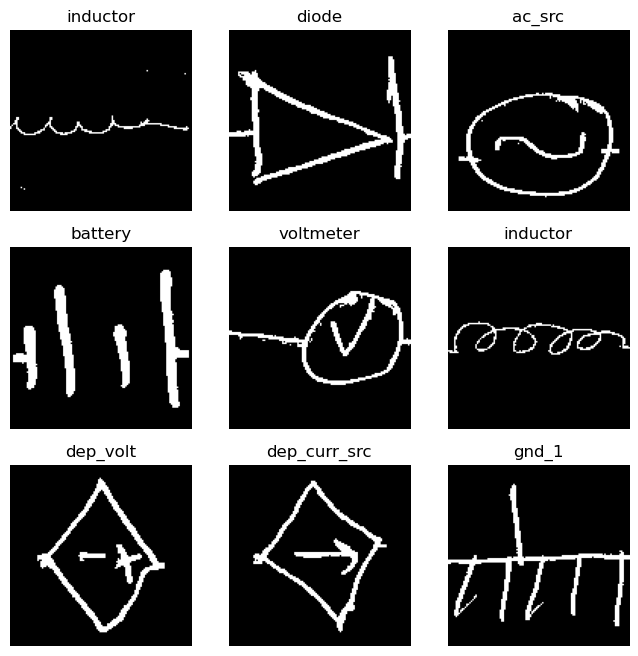

In [8]:
#Display the list of labels
print("Label Data:")
labels_map = trainset.classes
print(labels_map)

#Visualize some of the training set data
print("\nImage Data and Associated Labels:")
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(trainset), size=(1,)).item()
    img, label = trainset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## 2. Convolutional Neural Network Architecture

### 2.1. Specify the CNN's Architecture

In [9]:
#Define the CNN architecture
class ElecNET(nn.Module):
    def __init__(self, num_classes):
        super(ElecNET, self).__init__()
        
        #Convolutional and pooling layers follows layer trend of LeNET-5
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        #Fully connected layers and ReLU to calculate activations between layers
        self.classifier = nn.Sequential(
            nn.Linear(128 * 15 * 15, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes),
        )

    #Forward-pass of ElecNET
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

#Summary of the ElecNET architecture
net = ElecNET(num_classes=15)
print(net)

ElecNET(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=28800, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=15, bias=True)
  )
)


## 3. Training

### 3.1. Initialize Model, Parameters & Functions

In [10]:
#Define the number of folds for cross-validation
num_folds = 3

#Create an instance of ElecNET
model = ElecNET(15)

#Define cross-entropy loss fucntion
criterion = nn.CrossEntropyLoss()

#Define Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

#Create a splitter for k-fold cross-validation
kf = KFold(n_splits=num_folds, shuffle=True)

#Initialize running fold counter to zero
fold = 0

### 3.2. Model Training  & K-Fold Cross-Validation

Fold 1:


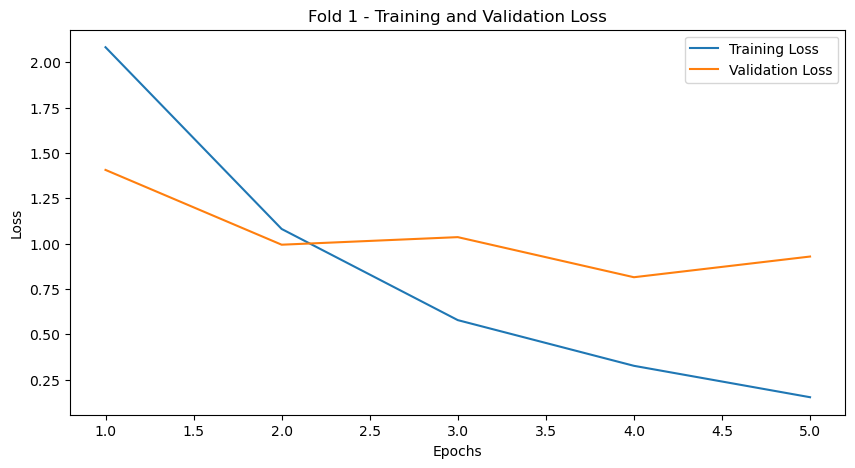

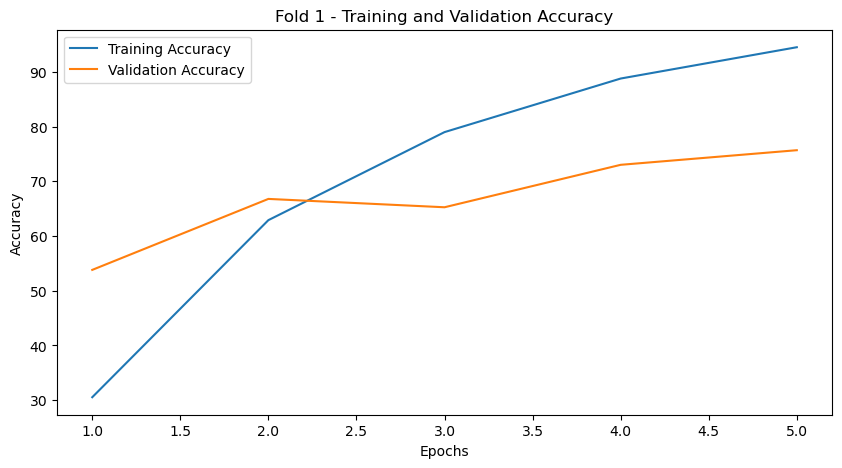

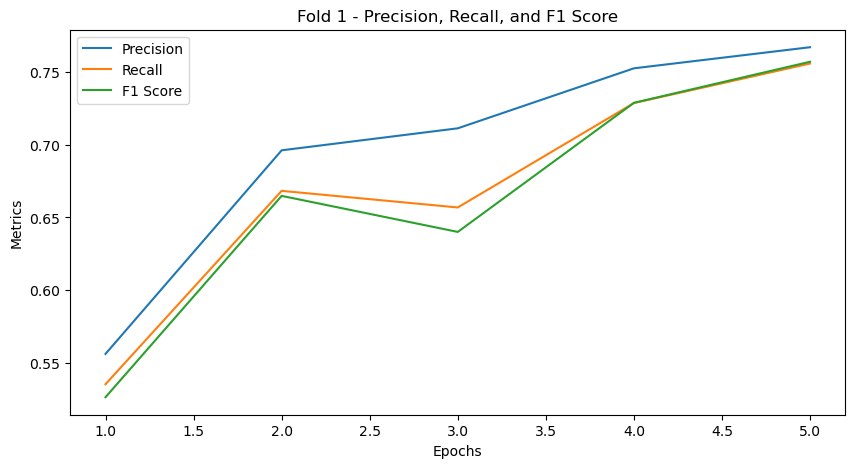

Fold 2:
Early stopping. No improvement in the F1 score.


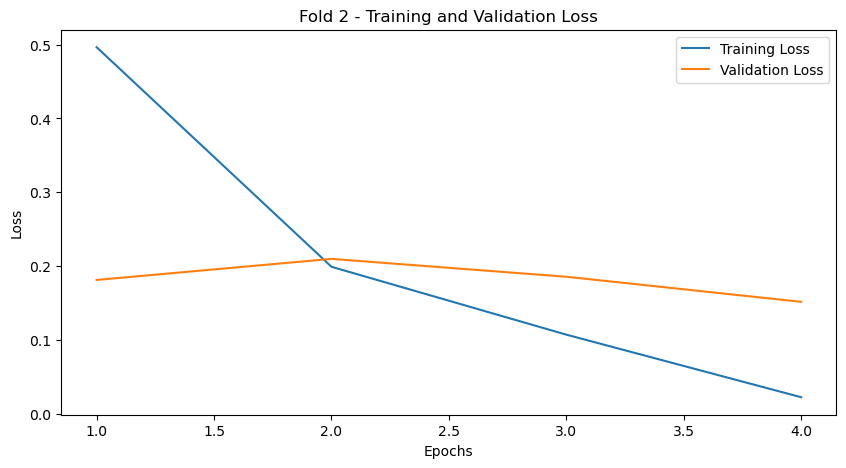

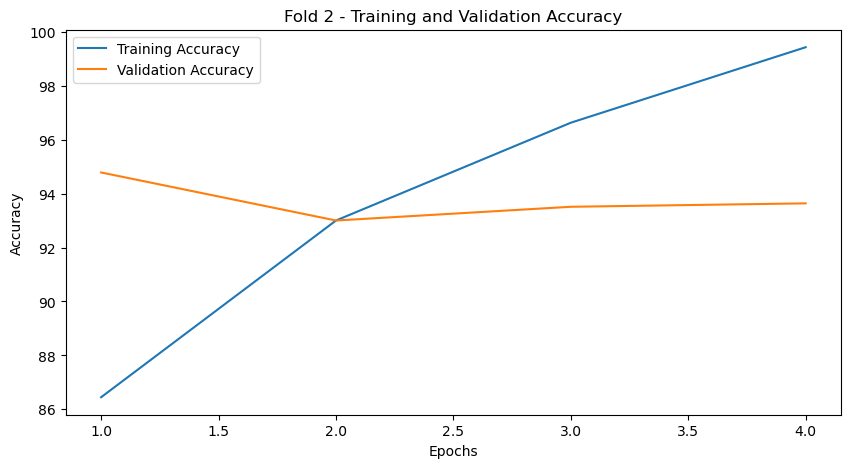

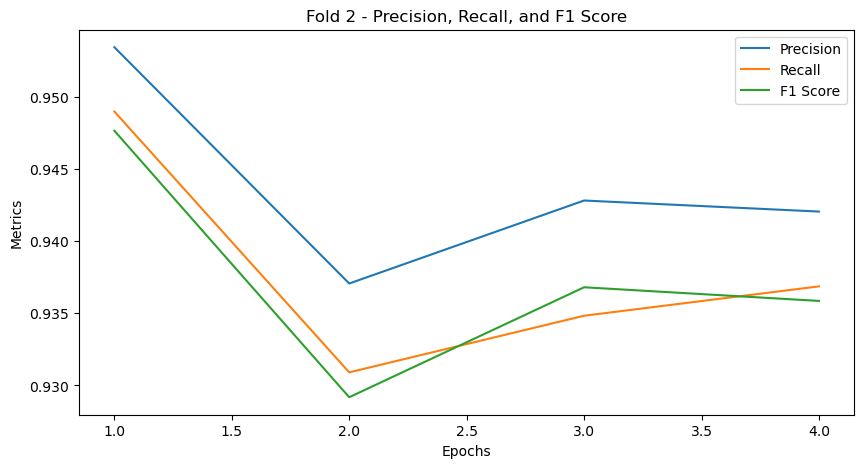

Fold 3:
Early stopping. No improvement in the F1 score.


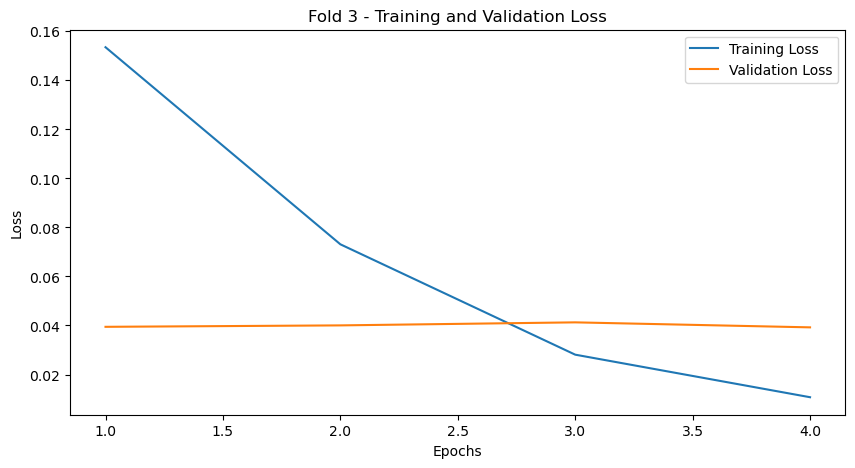

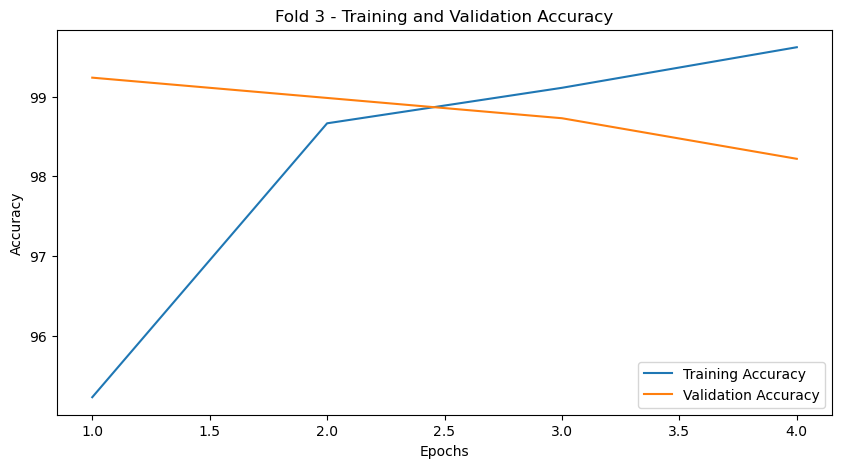

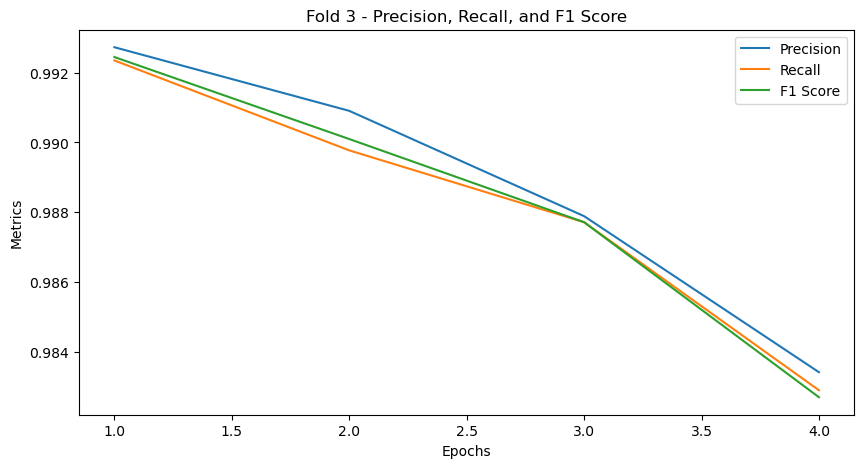

In [11]:
#Fold loop
for train_indices, val_indices in kf.split(trainset):
    fold += 1
    print(f"Fold {fold}:")

    #Create samplers for fold
    train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    valid_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

    # Create training and testing dataloaders for fold
    trainloader = DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
    validloader = DataLoader(trainset, batch_size=batch_size, sampler=valid_sampler)

    #Initialize variables for early stopping
    best_f1_score = 0.0
    patience = 3
    epochs_without_improvement = 0

    # Initialize lists to store metrics for each epoch
    train_loss_values = []
    train_accuracy_values = []
    val_loss_values = []
    val_accuracy_values = []
    precision_values = []
    recall_values = []
    f1_values = []
    
    #Initialize the number of epochs
    num_epochs = 5

    #Training and Validation loop for specified epochs
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        #Training loop
        for inputs, labels in trainloader:
            #Zero gradients
            optimizer.zero_grad()

            #Perform forward pass
            outputs = model(inputs)

            #Calculate loss
            loss = criterion(outputs, labels)

            #Perform backward pass
            loss.backward()

            #Update the weights and baises
            optimizer.step()

            #Calculate statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        #Calculate average loss per epoch
        avg_loss = running_loss / len(trainloader)

        #Calculate accuracy
        accuracy = 100 * correct / total

        #Append metrics to lists
        train_loss_values.append(avg_loss)
        train_accuracy_values.append(accuracy)

        #Evaluate the model on the validation set
        model.eval()
        true_labels = []
        predicted_labels = []
        val_loss = 0.0

        with torch.no_grad():
            for inputs, labels in validloader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)

                true_labels.extend(labels.tolist())
                predicted_labels.extend(predicted.tolist())

                #Calculate the validation loss
                val_loss += criterion(outputs, labels).item()

        #Calculate evaluation metrics on the validation set
        val_accuracy = 100 * torch.sum(torch.tensor(true_labels) == torch.tensor(predicted_labels)) / len(true_labels)
        avg_val_loss = val_loss / len(validloader)
        precision = precision_score(true_labels, predicted_labels, average='macro', zero_division=0)
        recall = recall_score(true_labels, predicted_labels, average='macro', zero_division=0)
        f1 = f1_score(true_labels, predicted_labels, average='macro', zero_division=0)

        #Append metrics to lists
        val_loss_values.append(avg_val_loss)
        val_accuracy_values.append(val_accuracy)
        precision_values.append(precision)
        recall_values.append(recall)
        f1_values.append(f1)

        #Check for early stopping based on the F1 score
        if f1 > best_f1_score:
            best_f1_score = f1
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement == patience:
            print("Early stopping. No improvement in the F1 score.")
            break
            
    #Save the model for the current fold
    torch.save(model.state_dict(), f"trained_models/trained_model_fold{fold}.pth")

    #Plot the training and validation loss for fold
    plt.figure(figsize=(10, 5))
    epochs = range(1, epoch + 2)
    plt.plot(epochs, train_loss_values, label='Training Loss')
    plt.plot(epochs, val_loss_values, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Fold {fold} - Training and Validation Loss')
    plt.legend()
    plt.show()

    #Plot the training and validation accuracy for fold
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_accuracy_values, label='Training Accuracy')
    plt.plot(epochs, val_accuracy_values, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Fold {fold} - Training and Validation Accuracy')
    plt.legend()
    plt.show()

    #Plot precision, recall, and F1 score for fold
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, precision_values, label='Precision')
    plt.plot(epochs, recall_values, label='Recall')
    plt.plot(epochs, f1_values, label='F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.title(f'Fold {fold} - Precision, Recall, and F1 Score')
    plt.legend()
    plt.show()

## 3. Testing

In [16]:
#Load the trained model state dictionary
model.load_state_dict(torch.load("trained_models/trained_model_fold3.pth"))

#Testing loop 
model.eval()
total = 0
correct = 0
true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in testloader:
        #Forward pass
        outputs = model(inputs)

        #Calculate the predicted labels
        _, predicted = torch.max(outputs.data, 1)

        #Update the total and correct predictions count
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        #Collect true and predicted labels for precision, recall, and F1 score
        true_labels.extend(labels.tolist())
        predicted_labels.extend(predicted.tolist())

#Calculate testing accuracy
accuracy = 100 * correct / total

#Calculate precision, recall, and F1 score
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')

#Print evaluation metrics for testing
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 84.18%
Precision: 0.8498
Recall: 0.8426
F1 Score: 0.8432
